In [1]:
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import graphviz 
import pandas as pd
import numpy as np
import re

In [2]:
df = pd.read_excel('./data/Analyze data.xlsx')

In [3]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [3]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'cv ', 'prime_key', 'krisha_id',
       'Unnamed: 3', 'price', 'Unnamed: 5', 'description', 'is_mortgaged',
       'seller', 'city', 'date_creation', 'num_views', 'is_hot', 'is_paid_up',
       'is_hyped_turbo', 'is_cold_entry', 'num_pictures', 'num_rooms', 'Area',
       'floor', 'total_floors', 'year_builded', 'ceiling_height', 'Region',
       'Address', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28'],
      dtype='object')

In [27]:
df['floor_percent'] = df['floor']/df['total_floors'] * 100

In [25]:
df['price_per_m2'] = df['price']//df['Area']

In [26]:
df['price_per_m2_ln'] = np.log(df['price_per_m2'])

In [16]:
cor = df[['price', 'price_per_m2_ln', 'price_per_m2', 'year_builded', 'total_floors', 'floor_percent', 'floor', 'Area', 'num_rooms']].corr()


In [17]:
import seaborn as sns

<AxesSubplot: >

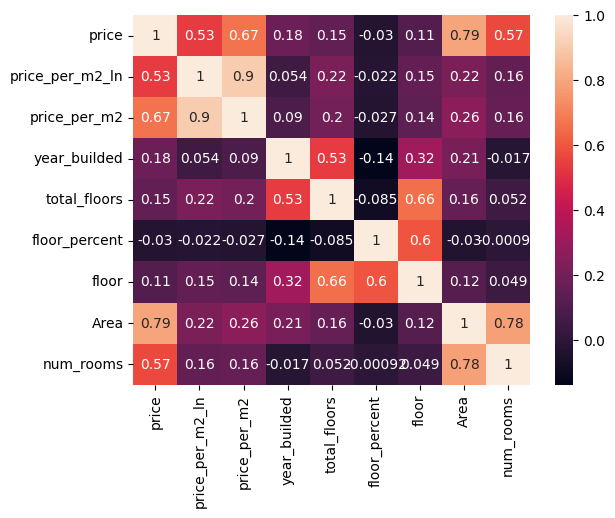

In [19]:
sns.heatmap(cor, annot=True)

In [88]:
cor.style.background_gradient(cmap='RdBu_r')

,price,price_per_m2_ln,price_per_m2,year_builded,total_floors,floor_percent,floor,Area,num_rooms
price,1.000000,0.534911,0.665806,0.177293,0.151347,-0.029551,0.112192,0.792805,0.569456
price_per_m2_ln,0.534911,1.000000,0.904468,0.053967,0.222551,-0.022373,0.154141,0.218954,0.156096
price_per_m2,0.665806,0.904468,1.000000,0.090381,0.200982,-0.027243,0.141317,0.262111,0.164545
year_builded,0.177293,0.053967,0.090381,1.000000,0.534130,-0.136142,0.317897,0.214297,-0.017260
total_floors,0.151347,0.222551,0.200982,0.534130,1.000000,-0.085038,0.655659,0.163742,0.051537
floor_percent,-0.029551,-0.022373,-0.027243,-0.136142,-0.085038,1.000000,0.596008,-0.029894,-0.000923
floor,0.112192,0.154141,0.141317,0.317897,0.655659,0.596008,1.000000,0.119337,0.049460
Area,0.792805,0.218954,0.262111,0.214297,0.163742,-0.029894,0.119337,1.000000,0.782176
num_rooms,0.569456,0.156096,0.164545,-0.017260,0.051537,-0.000923,0.049460,0.782176,1.000000


In [24]:
df_onehot_regions = pd.get_dummies(df['Region'])

# concatenate the original dataframe with the one hot encoded dataframe
df_onehot1 = pd.concat([df, df_onehot_regions], axis=1)

In [25]:
df_onehot1 = df_onehot1[df_onehot1['seller'] != 'New builded house']

In [26]:
df_onehot1.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'cv ', 'prime_key', 'krisha_id',
       'Unnamed: 3', 'price', 'Unnamed: 5', 'description', 'is_mortgaged',
       'seller', 'city', 'date_creation', 'num_views', 'is_hot', 'is_paid_up',
       'is_hyped_turbo', 'is_cold_entry', 'num_pictures', 'num_rooms', 'Area',
       'floor', 'total_floors', 'year_builded', 'ceiling_height', 'Region',
       'Address', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'floor_percent', 'price_per_m2', 'price_per_m2_ln', 'Alatau district',
       'Almalinsky district', 'Auezov district', 'Bostandyk district',
       'Medeu district', 'Nauryzbay district', 'Turksib district',
       'Zhetysu district', 'Торекулова'],
      dtype='object')

Linear Model Y~X1 +...+Xn for non New builded house (Cold Entry excluded)

In [17]:
lm = LinearRegression().fit(X=df_onehot1[['floor_percent', 'ceiling_height', 'year_builded', 'num_views', 'num_rooms', 'total_floors','Alatau district', 'Almalinsky district', 'Auezov district', 'Bostandyk district', 'Medeu district', 'Nauryzbay district','Turksib district', 'Zhetysu district', 'Торекулова' ]], y= df_onehot1['price_per_m2'])

In [18]:
lm.score(X=df_onehot1[['floor_percent', 'ceiling_height', 'year_builded', 'num_views', 'num_rooms', 'total_floors','Alatau district', 'Almalinsky district', 'Auezov district', 'Bostandyk district', 'Medeu district', 'Nauryzbay district','Turksib district', 'Zhetysu district', 'Торекулова' ]], y= df_onehot1['price_per_m2'])

0.28827145715349956

Accuracy is not satisfying

Test different model ln Y ~ X1 +...+ Xn

In [6]:
import math 

In [7]:
df['price_per_m2_ln'] = df['price_per_m2'].apply(lambda x: math.log(float(x)))

In [27]:
lm2 = LinearRegression().fit(X=df_onehot1[['floor_percent', 'ceiling_height', 'year_builded', 'num_views', 'num_rooms', 'total_floors','Alatau district', 'Almalinsky district', 'Auezov district', 'Bostandyk district', 'Medeu district', 'Nauryzbay district','Turksib district', 'Zhetysu district', 'Торекулова' ]], y= df_onehot1['price_per_m2_ln'])

In [52]:
print('R^2: ',lm2.score(X=df_onehot1[['floor_percent', 'ceiling_height', 'year_builded', 'num_views', 'num_rooms', 'total_floors','Alatau district', 'Almalinsky district', 'Auezov district', 'Bostandyk district', 'Medeu district', 'Nauryzbay district','Turksib district', 'Zhetysu district', 'Торекулова' ]], y= df_onehot1['price_per_m2_ln']))

R^2:  0.3962944079233053


In [51]:
print('Coefs:', lm2.coef_)
print('Intercept:', lm2.intercept_)

Coefs: [-2.14886582e-04  1.25923977e-02  2.02595541e-03 -2.61596274e-06
 -1.04432375e-02  2.41558030e-03 -2.02887786e-01  1.58723303e-01
  4.23831150e-02  2.57722192e-01  2.65673832e-01 -2.19624390e-01
 -1.95040381e-01 -1.06949885e-01  0.00000000e+00]
Intercept: 9.284035251751828


that is better

Decision trees using CV K fold and Y is ln price per m2

In [90]:
dtree = GridSearchCV(tree.DecisionTreeRegressor(), {'max_depth':range(2,20)}, cv=10)

In [91]:
dtree.fit(X=df_onehot1[['floor_percent', 'ceiling_height', 'year_builded', 'num_views', 'num_rooms', 'total_floors','Alatau district', 'Almalinsky district', 'Auezov district', 'Bostandyk district', 'Medeu district', 'Nauryzbay district','Turksib district', 'Zhetysu district', 'Торекулова' ]], y= df_onehot1['price_per_m2_ln'])

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(2, 20)})

In [92]:
tree_model = dtree.best_estimator_
print (dtree.best_score_, dtree.best_params_) 

0.5077550442794612 {'max_depth': 8}


In [93]:
tree_model.score(X=df_onehot1[['floor_percent', 'ceiling_height', 'year_builded', 'num_views', 'num_rooms', 'total_floors','Alatau district', 'Almalinsky district', 'Auezov district', 'Bostandyk district', 'Medeu district', 'Nauryzbay district','Turksib district', 'Zhetysu district', 'Торекулова' ]], y= df_onehot1['price_per_m2_ln'])

0.5868667422410931

In [49]:
dot_data = tree.export_graphviz(tree_model, out_file=None, filled=True)
graph = graphviz.Source(dot_data)

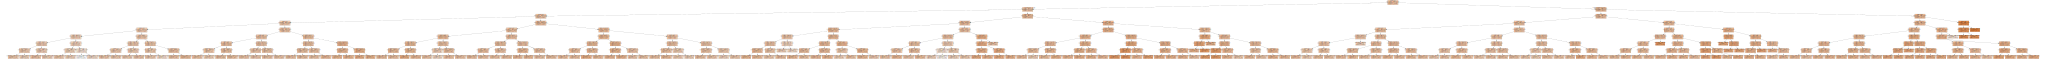

In [50]:
graph

That's cooler

Decision tree for Y is price per m2 (check for just in case)

In [38]:
dtree.fit(X=df_onehot1[['floor_percent', 'ceiling_height', 'year_builded', 'num_views', 'num_rooms', 'total_floors','Alatau district', 'Almalinsky district', 'Auezov district', 'Bostandyk district', 'Medeu district', 'Nauryzbay district','Turksib district', 'Zhetysu district', 'Торекулова' ]], y= df_onehot1['price_per_m2'])

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(2, 20)})

In [42]:
tree_model1 = dtree.best_estimator_
print (dtree.best_score_, dtree.best_params_) 

0.4077677272794375 {'max_depth': 5}


In [43]:
tree_model1.score(X=df_onehot1[['floor_percent', 'ceiling_height', 'year_builded', 'num_views', 'num_rooms', 'total_floors','Alatau district', 'Almalinsky district', 'Auezov district', 'Bostandyk district', 'Medeu district', 'Nauryzbay district','Turksib district', 'Zhetysu district', 'Торекулова' ]], y= df_onehot1['price_per_m2'])

0.4755006508507251

log Price per m2 seem to have more predictive potential 

Random Forest time for ln(Price per m2), 44% R^2 was with general Price per m2

In [63]:
size_recommended = len(['floor_percent', 'ceiling_height', 'year_builded', 'num_views', 'num_rooms', 'total_floors','Alatau district', 'Almalinsky district', 'Auezov district', 'Bostandyk district', 'Medeu district', 'Nauryzbay district','Turksib district', 'Zhetysu district', 'Торекулова' ])**0.5

In [64]:
size_recommended

3.872983346207417

4 should be enough but i see the problem with hot encoded data

In [107]:
forest = RandomForestRegressor(random_state=0, n_estimators=1000, max_features=4, max_depth=10)

In [108]:
forest.fit(X=df_onehot1[['floor_percent', 'ceiling_height', 'year_builded', 'num_views', 'num_rooms', 'total_floors','Alatau district', 'Almalinsky district', 'Auezov district', 'Bostandyk district', 'Medeu district', 'Nauryzbay district','Turksib district', 'Zhetysu district', 'Торекулова' ]], y= df_onehot1['price_per_m2_ln'])

RandomForestRegressor(max_depth=10, max_features=4, n_estimators=1000,
                      random_state=0)

In [109]:
forest.score(X=df_onehot1[['floor_percent', 'ceiling_height', 'year_builded', 'num_views', 'num_rooms', 'total_floors','Alatau district', 'Almalinsky district', 'Auezov district', 'Bostandyk district', 'Medeu district', 'Nauryzbay district','Turksib district', 'Zhetysu district', 'Торекулова' ]], y= df_onehot1['price_per_m2_ln'])

0.6596348894432054

I expect it to work less efficient since ont hot encoded should go together to make full effect 

In [4]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
KNeighborsRegressor(n_neighbors=5).fit()

In [5]:
from sklearn.decomposition import PCA

In [8]:
import seaborn as sns

<AxesSubplot: xlabel='floor', ylabel='total_floors'>

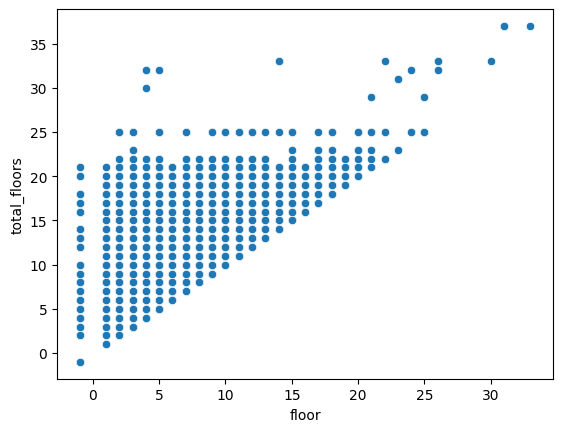

In [10]:
sns.scatterplot(df,x='floor', y='total_floors')

In [12]:
floor_pca = PCA(1).fit(df[['floor','total_floors']])

<AxesSubplot: ylabel='price'>

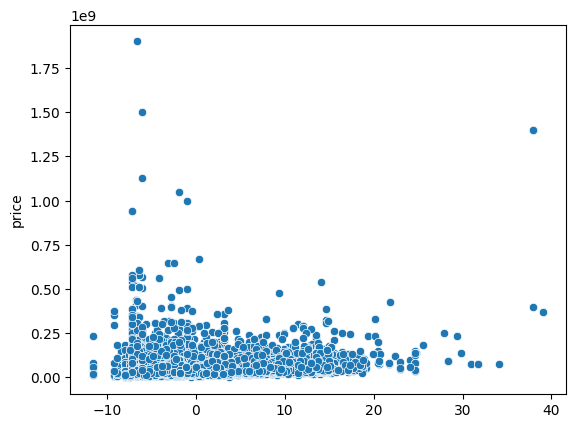

In [20]:
sns.scatterplot(x=,y=df['price'] )floor_pca.transform(df[['floor','total_floors']]).T[0]

<AxesSubplot: ylabel='price_per_m2_ln'>

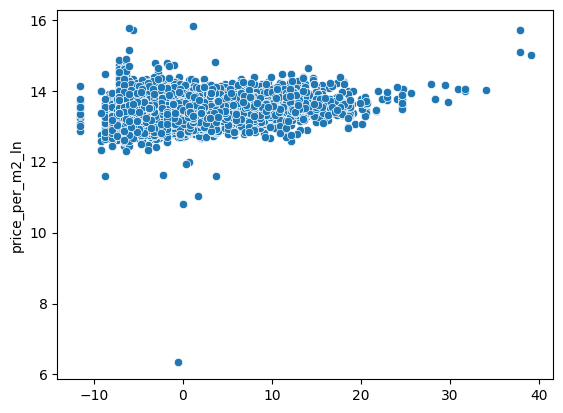

In [31]:
sns.scatterplot(x=floor_pca.transform(df[['floor','total_floors']]).T[0],y=df['price_per_m2_ln'] )

<AxesSubplot: xlabel='floor', ylabel='price_per_m2_ln'>

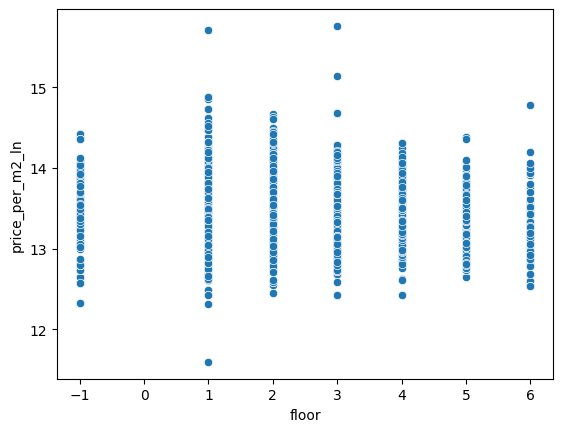

In [34]:
sns.scatterplot(x=df[df['total_floors'] < 7 ]['floor'],y=df[df['total_floors'] < 7]['price_per_m2_ln'] )